In [20]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.plot import plot_ofat, plot_ofat_final_step
from scipy.stats import norm, shapiro

# Analysis

`default_agent_results.csv` and `default_model_results.csv` were obtained by running `python src/experiment.py` with `save_agent_data` set to true in config.toml

In [70]:
model_data = pd.read_csv('../results/model_results.csv')
agent_data = pd.read_csv('../results/agent_results.csv')

In [71]:
agent_df = agent_data.groupby('iteration').mean().reset_index()

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_48890/1349170598.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_agent['trading_skill_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_48890/1349170598.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_agent['risk_aversion_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_48890/1349170598.py:11: FutureWarning: The default value of observed=False is deprec

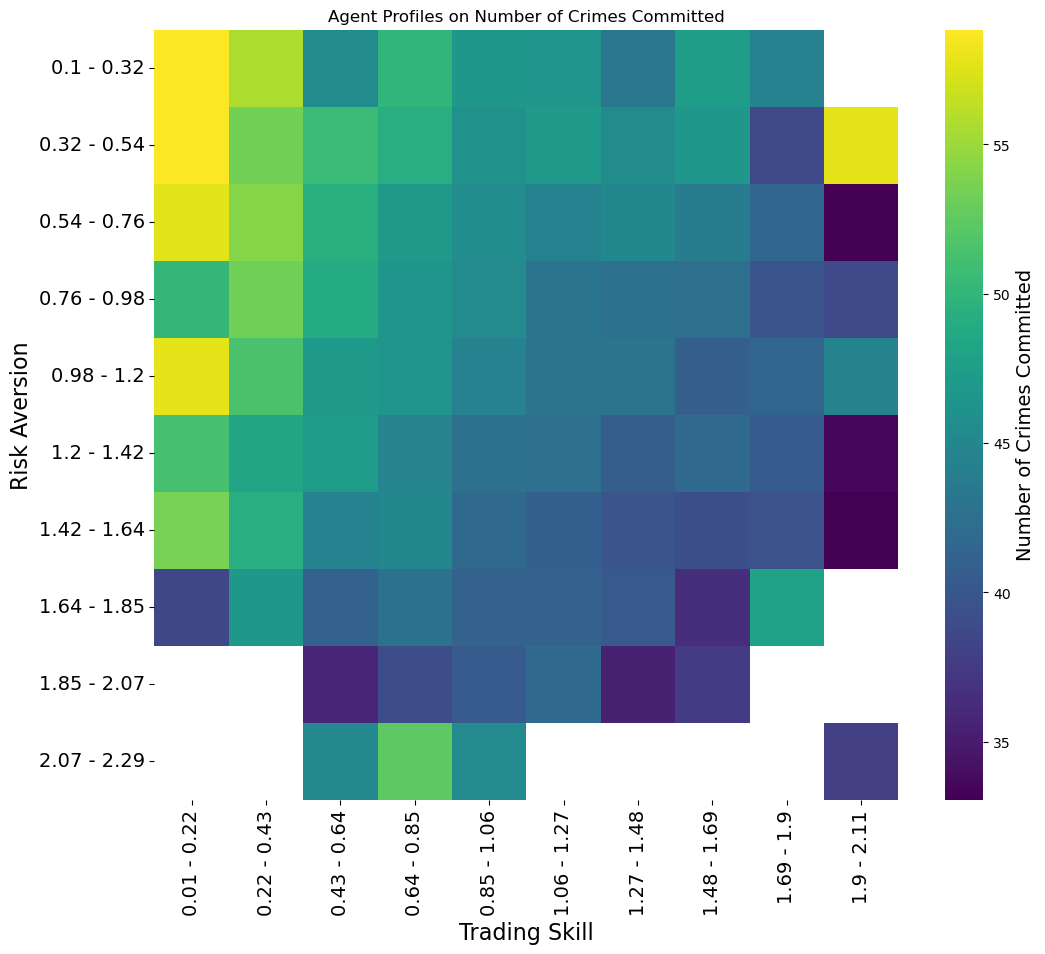

In [73]:
heatmap_agent = agent_data[['trading_skill', 'risk_aversion', 'crimes_committed_agent']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_agent['trading_skill'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_agent['risk_aversion'], bins=10)

heatmap_agent['trading_skill_binned'] = gini_bins
heatmap_agent['risk_aversion_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_agent.pivot_table(values='crimes_committed_agent', 
                                      index='trading_skill_binned', 
                                      columns='risk_aversion_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
heat_map = sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': 'Number of Crimes Committed'})
cbar = heat_map.collections[0].colorbar
cbar.set_label('Number of Crimes Committed', size=14)
plt.title('Agent Profiles on Number of Crimes Committed')
plt.xlabel('Trading Skill', fontsize=16)
plt.ylabel('Risk Aversion', fontsize=16)

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=90, fontsize=14)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0, fontsize=14)
plt.show()

Now we want to see how the distribution of agents trading skill and economic inequality at the final step of the simulation affect crime rates

### Overlay plot of crime reduction
Crime rates under different sentence lengths and number of cops. Csv file obtained by running `python src/experiment.py --vary sentence_length`

In [13]:
vary_sentence_data = pd.read_csv('../results/vary_sentence_length_results.csv') 

In [14]:
final_grouped = vary_sentence_data.groupby(['sentence_length', 'Step']).agg({
    'num_arrests_made': ['mean', 'std'],
    'num_crimes_committed': ['mean', 'std']
}).reset_index()
final_grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in final_grouped.columns.values]
final_grouped

,sentence_length,Step,num_arrests_made_mean,num_arrests_made_std,num_crimes_committed_mean,num_crimes_committed_std
0,5,1,1.100,1.172331,150.70,12.208026
1,5,2,3.800,2.197901,298.45,17.087932
2,5,3,5.675,2.692701,441.85,18.654140
3,5,4,7.800,3.495051,582.50,22.448802
4,5,5,9.550,3.594511,718.85,23.195435
...,...,...,...,...,...,...
4995,90,496,241.350,7.430188,14943.95,1167.446961
4996,90,497,241.525,7.595503,14957.55,1167.840302
4997,90,498,241.875,7.666736,14972.60,1168.693963
4998,90,499,242.250,7.611563,14986.30,1171.122324


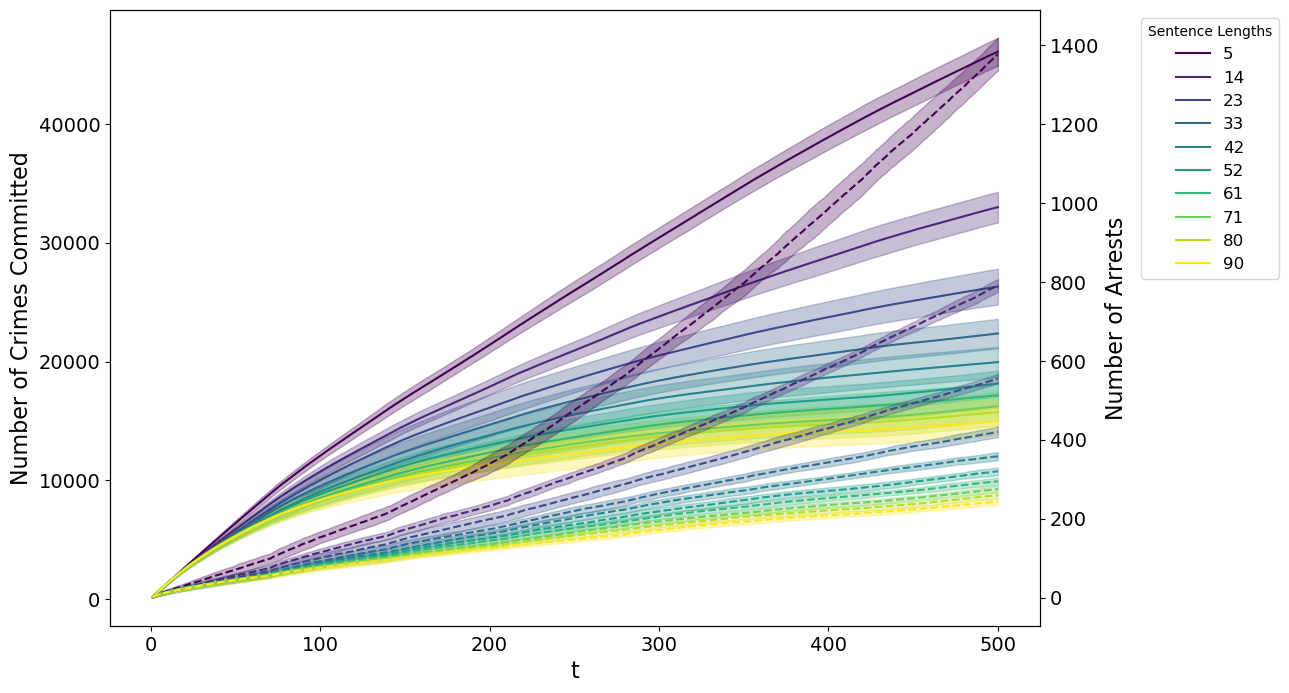

In [42]:
fig, ax1 = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(vary_sentence_data['sentence_length'].unique())))

# Create a second y-axis for the number of cops
ax2 = ax1.twinx()

# Plotting
for idx, (sentence_length, color) in enumerate(zip(sorted(vary_sentence_data['sentence_length'].unique()), colors)):
    subset = final_grouped[final_grouped['sentence_length'] == sentence_length]

    # Line plot for number of crimes committed with std fill
    mean_crimes = subset['num_crimes_committed_mean']
    std_crimes = subset['num_crimes_committed_std']
    ax1.plot(subset['Step'], mean_crimes, label=f'{sentence_length}', color=color)
    ax1.fill_between(subset['Step'], mean_crimes - std_crimes, mean_crimes + std_crimes, color=color, alpha=0.3)
    
    # Line plot for number of cops with std fill on second y-axis
    mean_cops = subset['num_arrests_made_mean']
    std_cops = subset['num_arrests_made_std']
    ax2.plot(subset['Step'], mean_cops, label=f'Sentence Length {sentence_length}', linestyle='--', color=color)
    ax2.fill_between(subset['Step'], mean_cops - std_cops, mean_cops + std_cops, color=color, alpha=0.3)

ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax1.set_xlabel('t', fontsize=16)
ax1.set_ylabel('Number of Crimes Committed', fontsize=16)
ax2.set_ylabel('Number of Arrests', fontsize=16)
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.1, 1), title="Sentence Lengths", fontsize=12)

plt.show()

In [61]:
model_data_at_last_step = model_data[model_data['Step'] == 500]

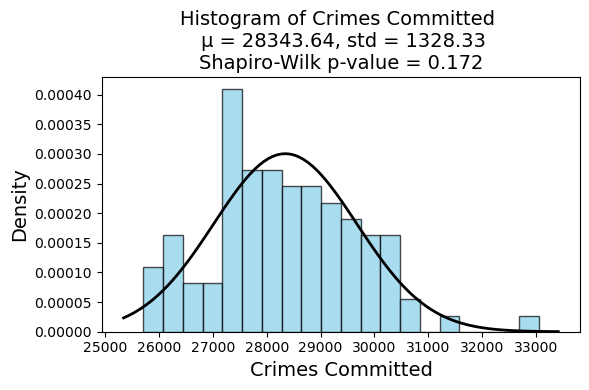

In [62]:
columns_to_plot = ['num_crimes_committed']
labels = {
    'num_crimes_committed': 'Crimes Committed',
    'num_cops': 'Number of Cops',
    'gini_coeff': 'Gini Coefficient',
    'total_wealth': 'Average Population Wealth'
}

fig, ax = plt.subplots(figsize=(6, 4))

for i, col in enumerate(columns_to_plot):
    mean_value_at_last_step = model_data_at_last_step.groupby(['iteration'])[col].mean().reset_index()

    # Calculate the mean and standard deviation for the normal distribution
    mu, std = norm.fit(mean_value_at_last_step[col].dropna())

    # Plot the histogram of the data
    n, bins, patches = ax.hist(mean_value_at_last_step[col].dropna(), bins=20, density=True, color='skyblue', edgecolor='black', alpha=0.7)

    # Create a range of values from min to max in a fine range
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)

    # Calculate the normal distribution's PDF on the range
    p = norm.pdf(x, mu, std)

    # Plot the PDF line
    ax.plot(x, p, 'k', linewidth=2)
    title = f'μ = {mu:.2f}, std = {std:.2f}'

    # Perform Shapiro-Wilk test
    stat, p_value = shapiro(mean_value_at_last_step[col].dropna())
    title += f'\nShapiro-Wilk p-value = {p_value:.3g}'

    ax.set_title(f'Histogram of {labels[col]} \n {title}', fontsize=14)
    ax.set_xlabel(f'{labels[col]}', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)

plt.tight_layout()
plt.show()

# OFAT SA
One Factor at A Time (OFAT or OFaaT) SA is a method of testing the output variance of inputs one at a time. Make sure to run the experiment to generate the csv files, depending on the type of parameter you want to vary.

### Sentence Length
Analyze how varying sentence length would affect the model outputs

In [74]:
sentence_data = pd.read_csv('../results/vary_sentence_length_results.csv')

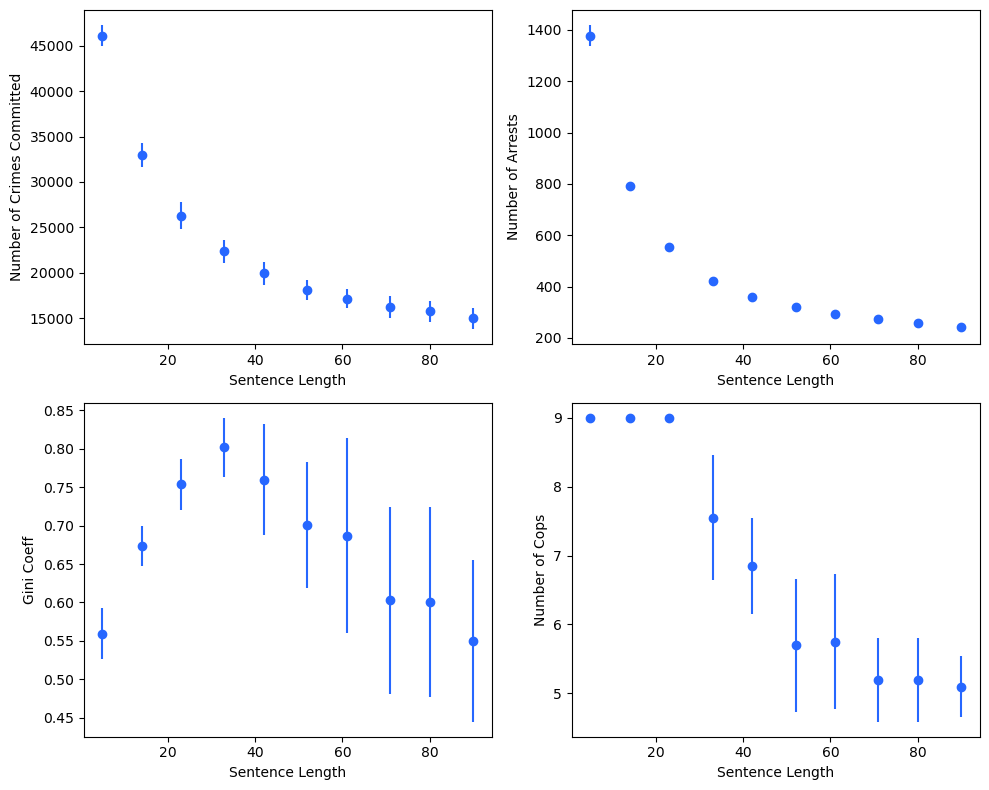

In [3]:
plot_ofat_final_step(sentence_data, 'sentence_length', 500)

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_48890/3503279294.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['gini_coeff_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_48890/3503279294.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['sentence_length_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_48890/3503279294.py:12: FutureWarning: The default value of observed=False is deprecated an

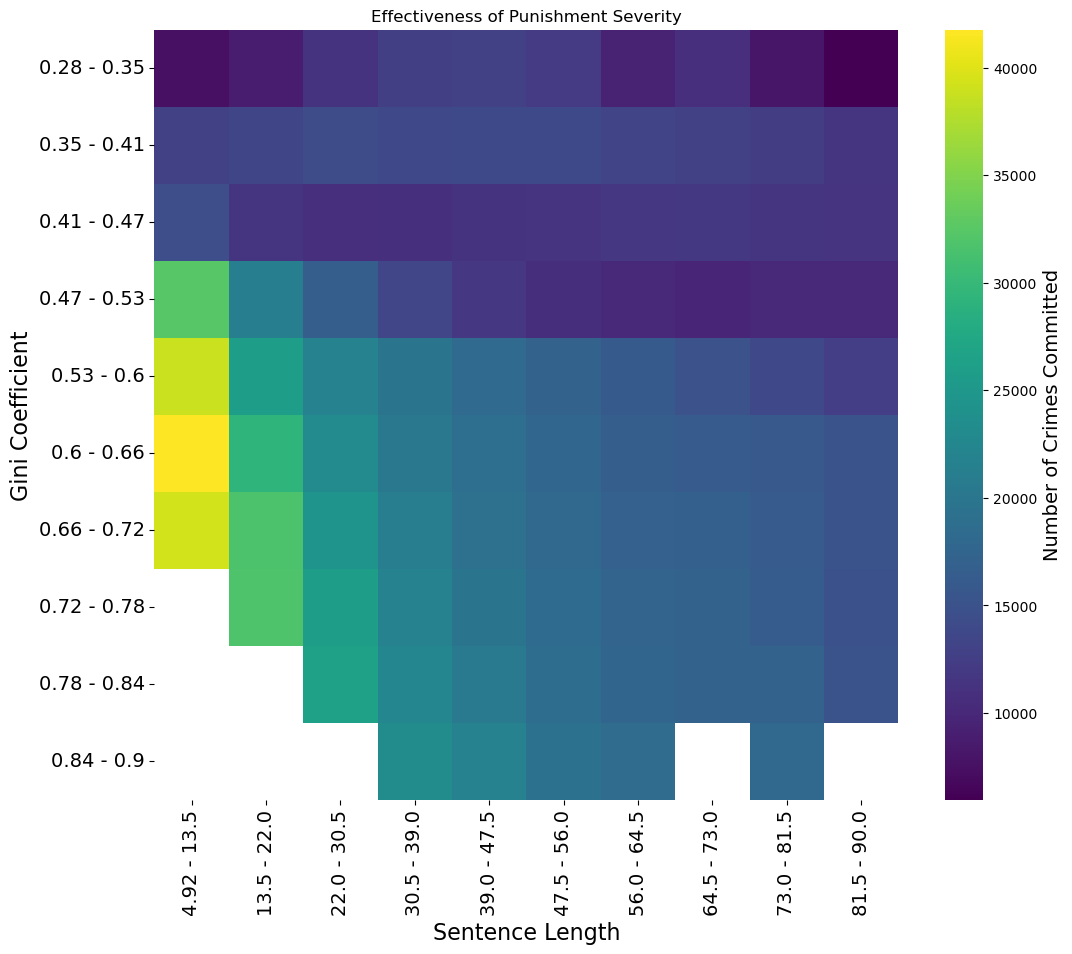

In [84]:
avg_sentence_data = sentence_data.groupby(['Step', 'sentence_length']).mean().reset_index()
heatmap_df = sentence_data[['gini_coeff', 'sentence_length', 'num_crimes_committed']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_df['gini_coeff'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_df['sentence_length'], bins=10)

heatmap_df['gini_coeff_binned'] = gini_bins
heatmap_df['sentence_length_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_df.pivot_table(values='num_crimes_committed', 
                                      index='gini_coeff_binned', 
                                      columns='sentence_length_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
heat_map = sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': 'Number of Crimes Committed'})
cbar = heat_map.collections[0].colorbar
cbar.set_label('Number of Crimes Committed', size=14)
plt.title('Effectiveness of Punishment Severity')
plt.xlabel('Sentence Length', fontsize=16)
plt.ylabel('Gini Coefficient', fontsize=16)

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=90, fontsize=14)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0, fontsize=14)
plt.show()

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_48890/3797875417.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['gini_coeff_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_48890/3797875417.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['num_arrests_made_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_48890/3797875417.py:12: FutureWarning: The default value of observed=False is deprecated a

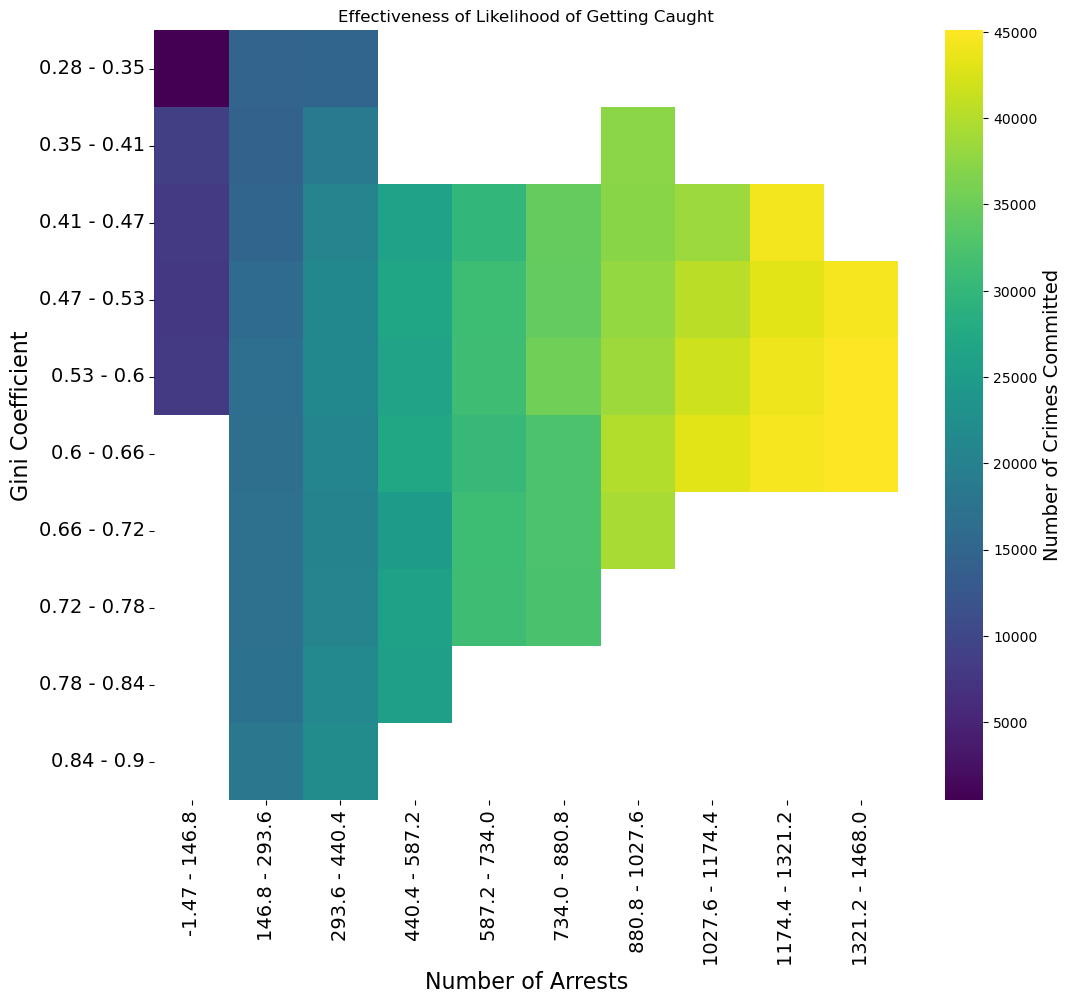

In [83]:
avg_sentence_data = sentence_data.groupby(['Step', 'sentence_length']).mean().reset_index()
heatmap_df = sentence_data[['gini_coeff', 'num_arrests_made', 'num_crimes_committed']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_df['gini_coeff'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_df['num_arrests_made'], bins=10)

heatmap_df['gini_coeff_binned'] = gini_bins
heatmap_df['num_arrests_made_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_df.pivot_table(values='num_crimes_committed', 
                                      index='gini_coeff_binned', 
                                      columns='num_arrests_made_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
heat_map = sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': 'Number of Crimes Committed'})
cbar = heat_map.collections[0].colorbar
cbar.set_label('Number of Crimes Committed', size=14)
plt.title('Effectiveness of Likelihood of Getting Caught')
plt.xlabel('Number of Arrests', fontsize=16)
plt.ylabel('Gini Coefficient', fontsize=16)

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=90, fontsize=14)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0, fontsize=14)
plt.show()

### Standard deviation in the distribution of risk aversion
to analyze how homogeneity and diversity in agents' risk profiles would affect the dynamics

In [4]:
risk_data = pd.read_csv('../results/vary_risk_results.csv')

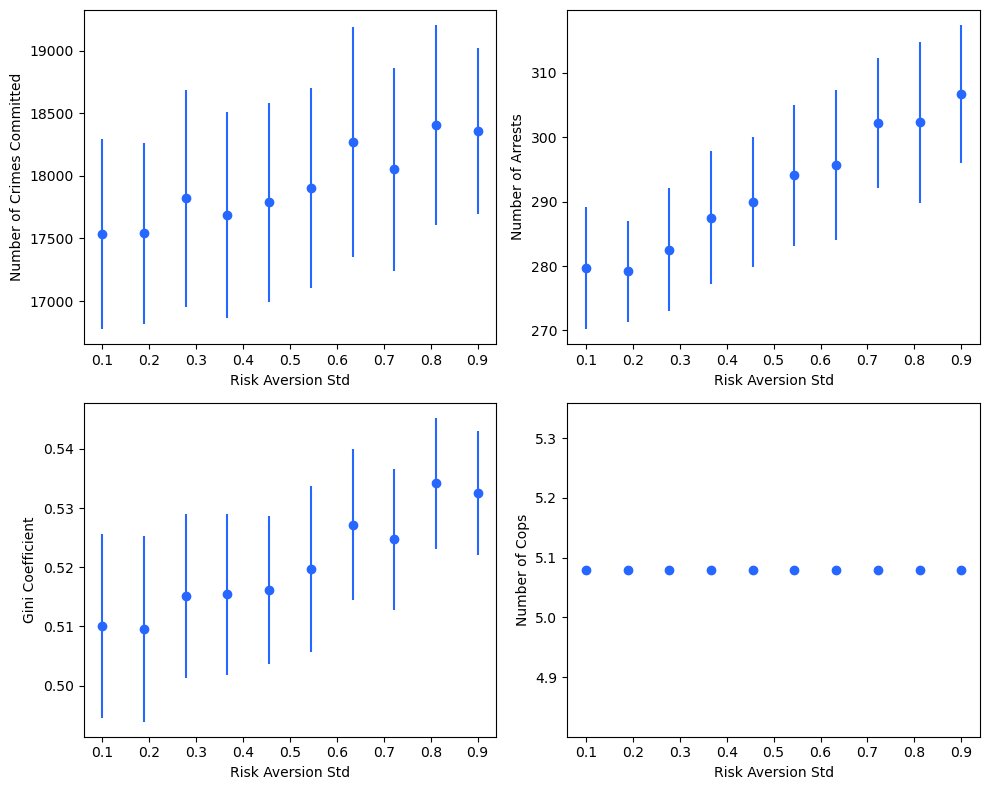

In [5]:
plot_ofat(risk_data, 'risk_aversion_std')

### Heatmap
To show the interplay between risk tolerance, economic capability (trading skills), and how these factors together shape the voting outcomes for policing levels

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_87425/2839296479.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['gini_coeff_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_87425/2839296479.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['risk_aversion_std_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_87425/2839296479.py:11: FutureWarning: The default value of observed=False is deprecated 

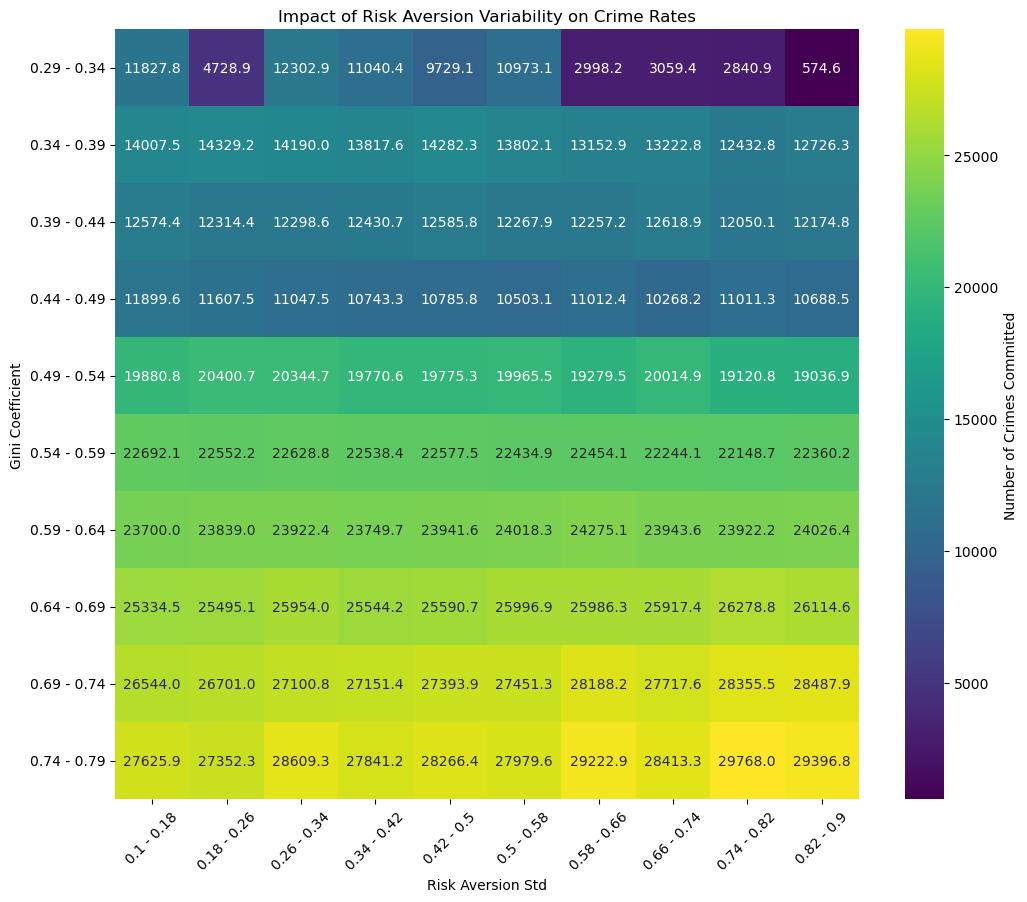

In [56]:
heatmap_df = risk_data[['gini_coeff', 'risk_aversion_std', 'num_crimes_committed']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_df['gini_coeff'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_df['risk_aversion_std'], bins=10)

heatmap_df['gini_coeff_binned'] = gini_bins
heatmap_df['risk_aversion_std_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_df.pivot_table(values='num_crimes_committed', 
                                      index='gini_coeff_binned', 
                                      columns='risk_aversion_std_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".1f", cbar_kws={'label': 'Number of Crimes Committed'})
plt.title('Impact of Risk Aversion Variability on Crime Rates')
plt.xlabel('Risk Aversion Std')
plt.ylabel('Gini Coefficient')

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=45)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0)
plt.show()

### Interaction Memory

In [6]:
memory_data = pd.read_csv('../results/vary_memory_results.csv')

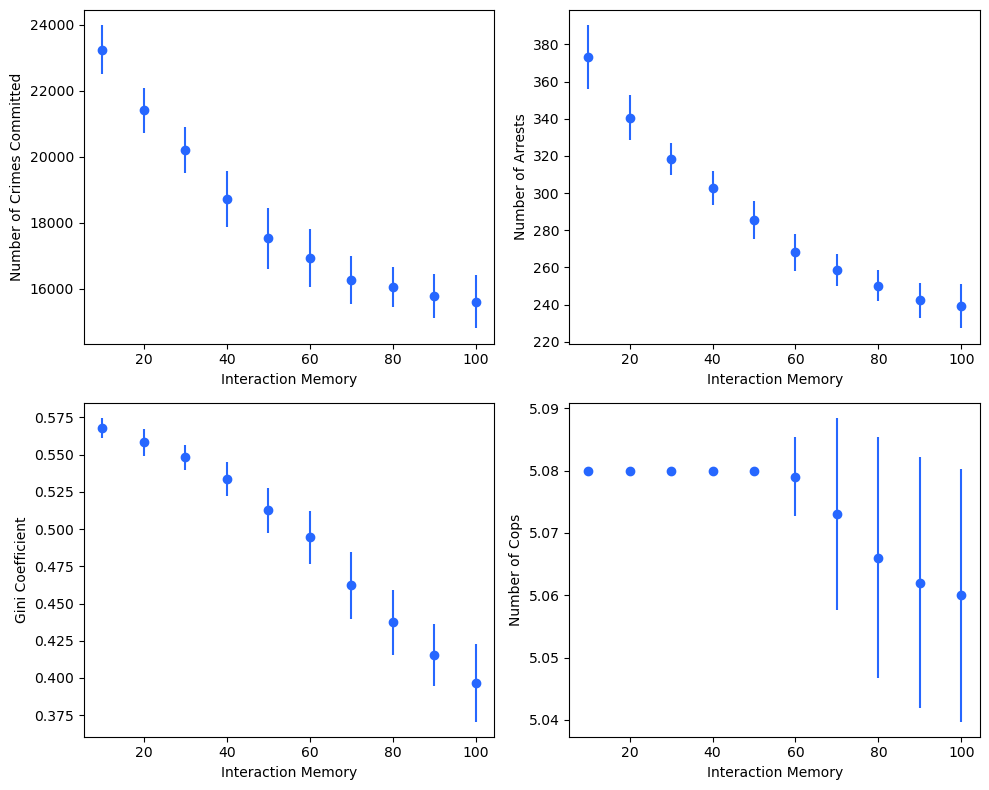

In [8]:
plot_ofat(memory_data, 'interaction_memory')

### Election Frequency

In [9]:
election_data = pd.read_csv('../results/vary_election_results.csv')

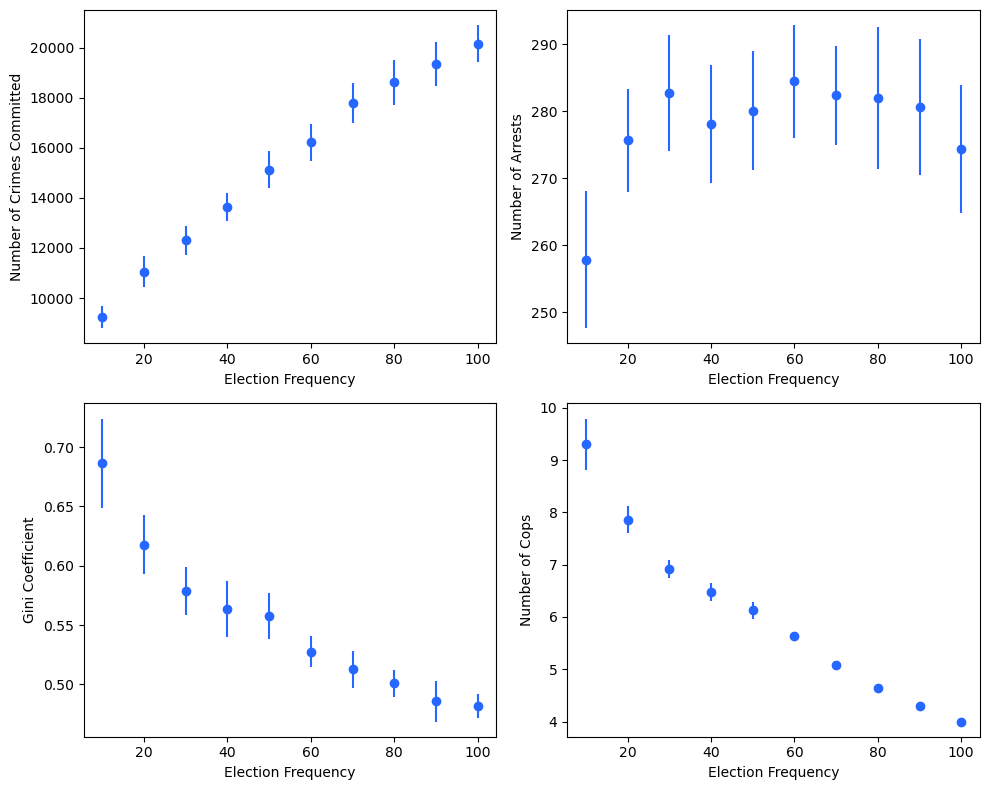

In [11]:
plot_ofat(election_data, 'election_frequency')

### Trading Skill

In [12]:
trade_data = pd.read_csv('../results/vary_trading_results.csv')

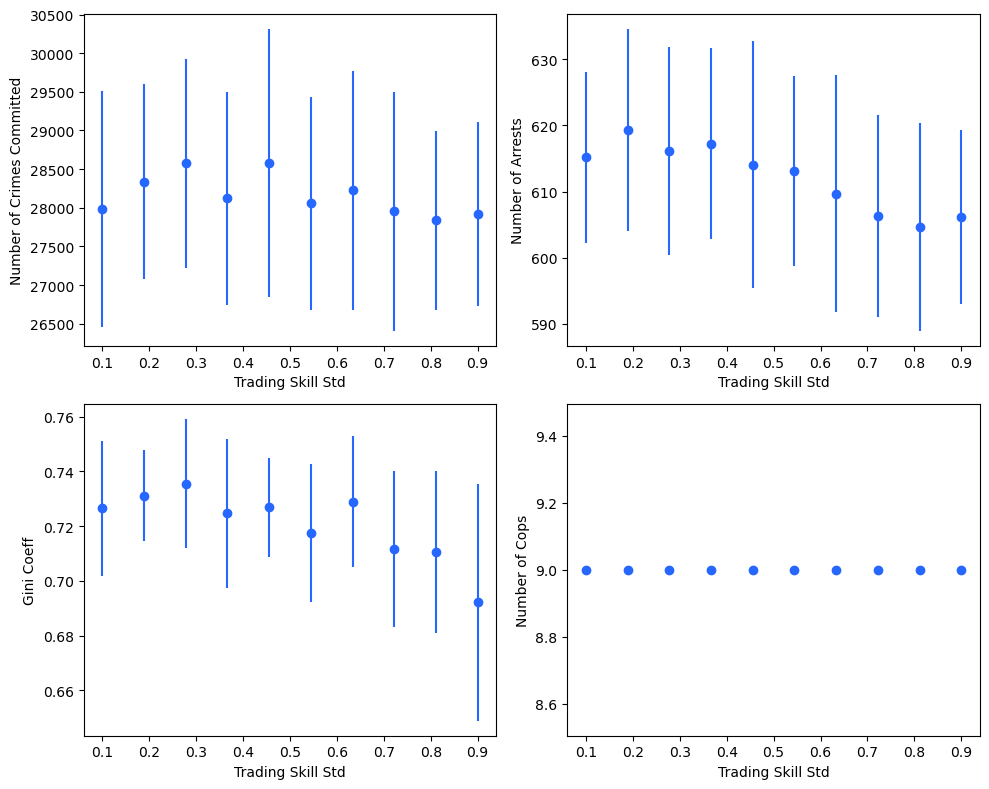

In [13]:
plot_ofat_final_step(trade_data , 'trading_skill_std', 500)

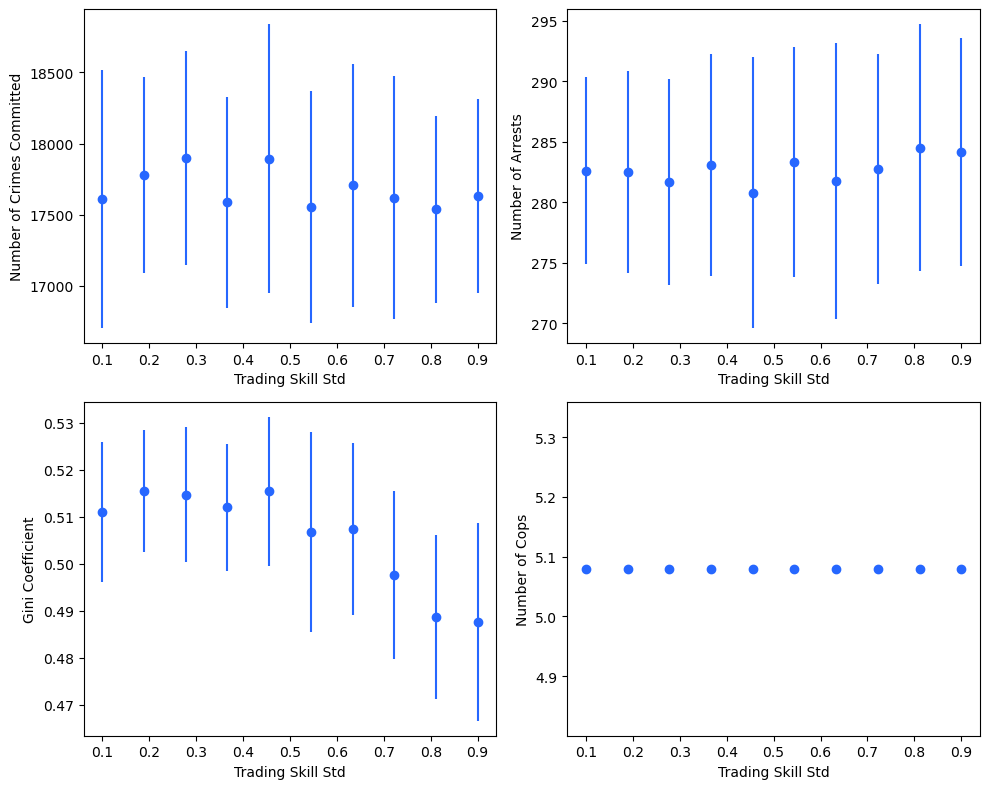

In [14]:
plot_ofat(trade_data , 'trading_skill_std')

### Heatmap
To show the interplay between risk tolerance, economic capability (trading skills), and how these factors together shape the voting outcomes for policing levels

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_87425/330953715.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['gini_coeff_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_87425/330953715.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['trading_skill_std_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_87425/330953715.py:11: FutureWarning: The default value of observed=False is deprecated and

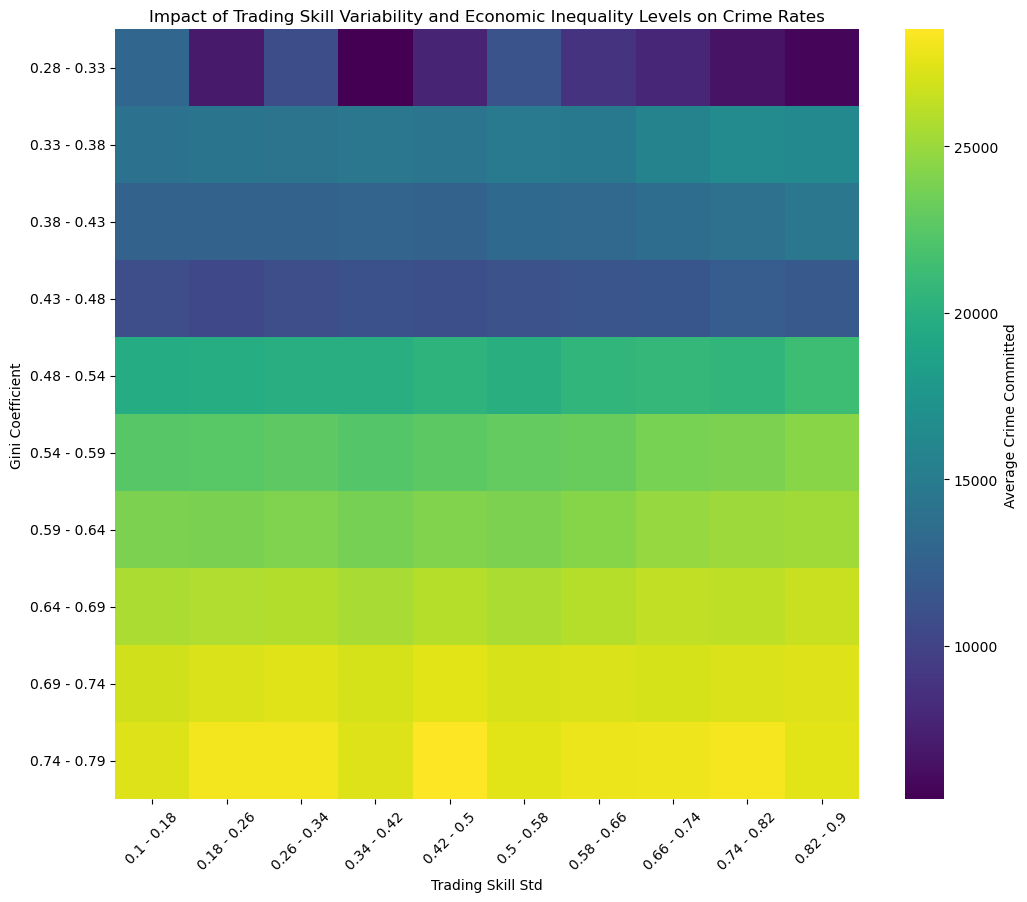

In [32]:
heatmap_df = trade_data[['gini_coeff', 'trading_skill_std', 'num_crimes_committed']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_df['gini_coeff'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_df['trading_skill_std'], bins=10)

heatmap_df['gini_coeff_binned'] = gini_bins
heatmap_df['trading_skill_std_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_df.pivot_table(values='num_crimes_committed', 
                                      index='gini_coeff_binned', 
                                      columns='trading_skill_std_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': 'Average Crime Committed'})
plt.title('Impact of Trading Skill Variability and Economic Inequality Levels on Crime Rates')
plt.xlabel('Trading Skill Std')
plt.ylabel('Gini Coefficient')

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=45)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0)
plt.show()

### Tax Rate for Cops

In [15]:
tax_data = pd.read_csv('../results/vary_tax_results.csv')

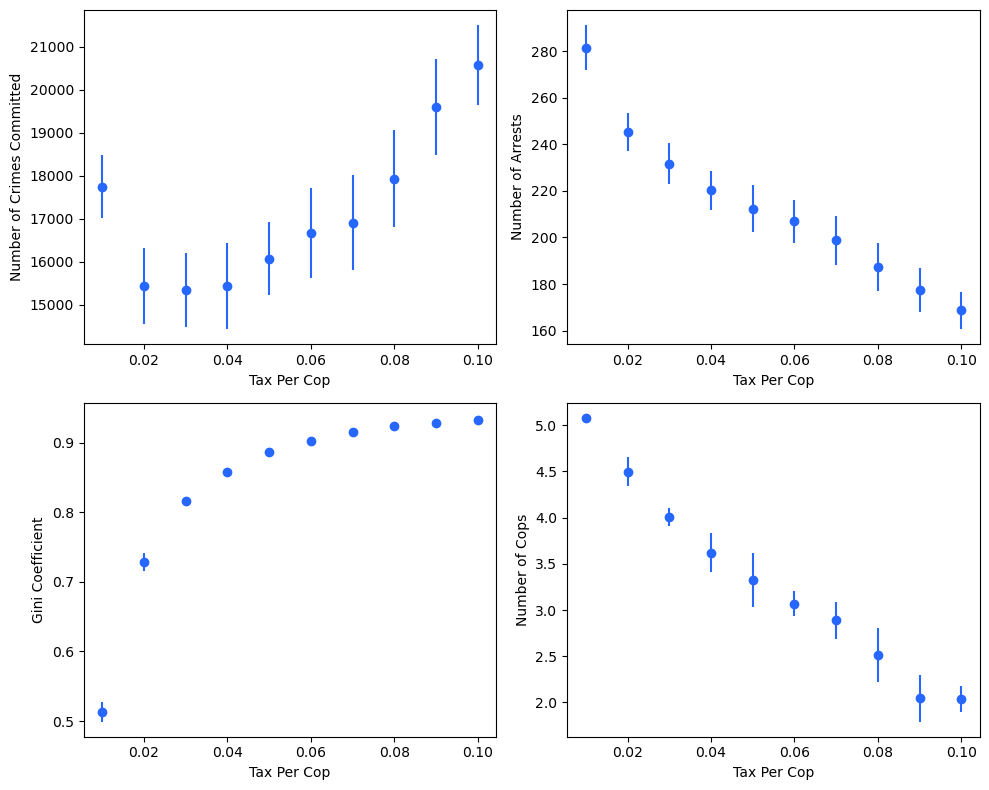

In [16]:
plot_ofat(tax_data , 'tax_per_cop')